In [2]:
from diffmain import *
from DataL import *
import glob
import sys
import os
import re
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pdb
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

In [3]:
def create_smaller_dataset(original_dataset, factor):
    # Calculate the size of the smaller dataset
    smaller_size = len(original_dataset) // factor

    # Randomly select indices for the smaller dataset
    smaller_indices = random.sample(range(len(original_dataset)), smaller_size)

    # Create the smaller dataset
    smaller_dataset = [original_dataset[i] for i in smaller_indices]

    return smaller_dataset

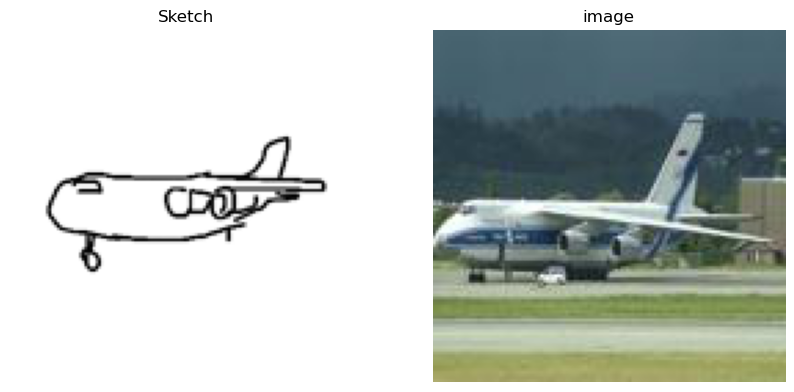

In [4]:

#photos_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/photo/resized'
#sketches_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/sketch/resized'

base_dir = os.getcwd()
photos_dir = os.path.join(base_dir, '256x256/photo/resized/airplane')
sketches_dir = os.path.join(base_dir, '256x256/sketch/resized/airplane')

transform = transforms.Compose([transforms.ToTensor()]) 
SketchySet = SketchyDataset(sketches_dir, photos_dir, transform=transform)
#torch.utils.data.DataLoader(SketchySet, batch_size=256)


i=random.randint(0,len(SketchySet)-1)
sk,im = SketchySet[i]

# Convert the tensors back to numpy arrays
sk = sk.numpy()
im = im.numpy()

sk=np.array(sk).transpose((1,2,0))
im=np.array(im).transpose((1,2,0))
#print(im)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sk)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(im)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()



In [5]:
diffusion_steps = 1000
architecture = "UNet"
sampling_steps = 250
DDIM = False


seed = 112233
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [6]:
model = unets.__dict__[architecture](
    image_size=128,
    in_channels=3,
    out_channels=3).to(device)

#model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))   

diffusion = GuassianDiffusion(diffusion_steps, device = device)

lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001)
ngpus = torch.cuda.device_count()

os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12355"
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

local_rank = int(os.getenv("LOCAL_RANK", "0"))

device = "cuda:{}".format(local_rank)
torch.cuda.set_device(device)
torch.manual_seed(seed + local_rank)
np.random.seed(seed + local_rank)
batch_size = 128

if torch.distributed.is_initialized():
    torch.distributed.destroy_process_group()

if ngpus > 1:
    if local_rank == 0:
        print(f"Using distributed training on {ngpus} gpus.")
    batch_size = batch_size // ngpus
    torch.distributed.init_process_group(backend="nccl", init_method="env://")
    model = DDP(model, device_ids=[local_rank], output_device=local_rank)

#train_set=create_smaller_dataset(get_miniset(), factor=50)

sampler = DistributedSampler(SketchySet) if ngpus > 1 else None

train_loader = DataLoader(SketchySet, batch_size=batch_size, sampler=sampler, num_workers=1, pin_memory=True)

if local_rank == 0:
    print(
        f"Training dataset loaded: Number of batches: {len(train_loader)}, Number of images: {len(SketchySet)}"
    )

Using distributed training on 8 gpus.
Training dataset loaded: Number of batches: 45, Number of images: 709


In [9]:
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Decays the learning rate by a factor of 0.1 every 30 epochs
# Other schedulers we can use are: StepLR, ExponentialLR, ReduceLROnPlateau

model.train()
Tloss = []
for epoch in tqdm(range(epochs)):
    totalloss=0
    #train_one_epoch(model, train_loader, optimizer, device, epoch, diffusion)
    for step, (sketch, photo) in enumerate(train_loader):
        assert (photo.max().item() <= 1) and (0 <= photo.min().item())
        photo = photo.to(device)
        sketch = sketch.to(device)
        photo, sketch = (2 * photo - 1, sketch)

        t = torch.randint(diffusion.timesteps, (len(photo),), dtype=torch.int64).to(device)
        
        xt, eps = diffusion.sample_from_forward_process(photo, t)
        pred_eps = model(xt, t, y = None)

        loss = ((pred_eps - eps) ** 2).mean()
        loss=loss/4
        totalloss+=loss.item()
        loss.backward()
        if step%4 == 0:
            optimizer.step()
            optimizer.zero_grad()  

    totalloss=totalloss/len(train_loader)
    Tloss.append(totalloss)
    scheduler.step()
    print("Epoch: ", epoch)
    print("Loss: ", loss.item())
    for param_group in optimizer.param_groups:
        print("Current learning rate is: ", param_group['lr'])

  1%|▌                                                         | 1/100 [00:17<28:42, 17.40s/it]

Epoch:  0
Loss:  0.012632757425308228
Current learning rate is:  0.001


  2%|█▏                                                        | 2/100 [00:34<28:25, 17.40s/it]

Epoch:  1
Loss:  0.01512643788009882
Current learning rate is:  0.001


  3%|█▋                                                        | 3/100 [00:52<28:08, 17.41s/it]

Epoch:  2
Loss:  0.012081857770681381
Current learning rate is:  0.001


  4%|██▎                                                       | 4/100 [01:09<28:05, 17.55s/it]

Epoch:  3
Loss:  0.005627721548080444
Current learning rate is:  0.001


  5%|██▉                                                       | 5/100 [01:27<27:50, 17.58s/it]

Epoch:  4
Loss:  0.0053887092508375645
Current learning rate is:  0.001


  6%|███▍                                                      | 6/100 [01:45<27:31, 17.56s/it]

Epoch:  5
Loss:  0.015019483864307404
Current learning rate is:  0.001


  7%|████                                                      | 7/100 [02:03<27:22, 17.66s/it]

Epoch:  6
Loss:  0.002348846523091197
Current learning rate is:  0.001


  8%|████▋                                                     | 8/100 [02:20<27:10, 17.73s/it]

Epoch:  7
Loss:  0.004053378943353891
Current learning rate is:  0.001


  9%|█████▏                                                    | 9/100 [02:38<26:48, 17.67s/it]

Epoch:  8
Loss:  0.018765177577733994
Current learning rate is:  0.001


 10%|█████▋                                                   | 10/100 [02:56<26:34, 17.72s/it]

Epoch:  9
Loss:  0.003354507265612483
Current learning rate is:  0.001


 11%|██████▎                                                  | 11/100 [03:13<26:10, 17.65s/it]

Epoch:  10
Loss:  0.005622946657240391
Current learning rate is:  0.001


 12%|██████▊                                                  | 12/100 [03:31<25:47, 17.58s/it]

Epoch:  11
Loss:  0.0024482228327542543
Current learning rate is:  0.001


 13%|███████▍                                                 | 13/100 [03:48<25:26, 17.55s/it]

Epoch:  12
Loss:  0.0029672053642570972
Current learning rate is:  0.001


 14%|███████▉                                                 | 14/100 [04:06<25:11, 17.58s/it]

Epoch:  13
Loss:  0.004815520253032446
Current learning rate is:  0.001


 15%|████████▌                                                | 15/100 [04:23<24:50, 17.53s/it]

Epoch:  14
Loss:  0.003652930958196521
Current learning rate is:  0.001


 16%|█████████                                                | 16/100 [04:41<24:30, 17.51s/it]

Epoch:  15
Loss:  0.013071674853563309
Current learning rate is:  0.001


 17%|█████████▋                                               | 17/100 [04:58<24:11, 17.49s/it]

Epoch:  16
Loss:  0.010858210735023022
Current learning rate is:  0.001


 18%|██████████▎                                              | 18/100 [05:16<23:52, 17.47s/it]

Epoch:  17
Loss:  0.0049591087736189365
Current learning rate is:  0.001


 19%|██████████▊                                              | 19/100 [05:33<23:34, 17.47s/it]

Epoch:  18
Loss:  0.0036285282112658024
Current learning rate is:  0.001


 20%|███████████▍                                             | 20/100 [05:50<23:17, 17.47s/it]

Epoch:  19
Loss:  0.0053612543269991875
Current learning rate is:  0.001


 21%|███████████▉                                             | 21/100 [06:08<23:00, 17.48s/it]

Epoch:  20
Loss:  0.0035286974161863327
Current learning rate is:  0.001


 22%|████████████▌                                            | 22/100 [06:25<22:43, 17.48s/it]

Epoch:  21
Loss:  0.006673115771263838
Current learning rate is:  0.001


 23%|█████████████                                            | 23/100 [06:43<22:32, 17.57s/it]

Epoch:  22
Loss:  0.02517423965036869
Current learning rate is:  0.001


 24%|█████████████▋                                           | 24/100 [07:01<22:21, 17.66s/it]

Epoch:  23
Loss:  0.0013967464910820127
Current learning rate is:  0.001


 25%|██████████████▎                                          | 25/100 [07:19<22:01, 17.63s/it]

Epoch:  24
Loss:  0.0063514565117657185
Current learning rate is:  0.001


 26%|██████████████▊                                          | 26/100 [07:36<21:40, 17.57s/it]

Epoch:  25
Loss:  0.02092907764017582
Current learning rate is:  0.001


 27%|███████████████▍                                         | 27/100 [07:54<21:27, 17.64s/it]

Epoch:  26
Loss:  0.005442306865006685
Current learning rate is:  0.001


 28%|███████████████▉                                         | 28/100 [08:11<21:09, 17.63s/it]

Epoch:  27
Loss:  0.010174525901675224
Current learning rate is:  0.001


 29%|████████████████▌                                        | 29/100 [08:29<20:53, 17.66s/it]

Epoch:  28
Loss:  0.007423927076160908
Current learning rate is:  0.001


 30%|█████████████████                                        | 30/100 [08:47<20:32, 17.60s/it]

Epoch:  29
Loss:  0.006138611119240522
Current learning rate is:  0.0001


 31%|█████████████████▋                                       | 31/100 [09:04<20:10, 17.55s/it]

Epoch:  30
Loss:  0.004945994820445776
Current learning rate is:  0.0001


 32%|██████████████████▏                                      | 32/100 [09:22<19:50, 17.51s/it]

Epoch:  31
Loss:  0.008950735442340374
Current learning rate is:  0.0001


 33%|██████████████████▊                                      | 33/100 [09:39<19:31, 17.49s/it]

Epoch:  32
Loss:  0.01120181567966938
Current learning rate is:  0.0001


 34%|███████████████████▍                                     | 34/100 [09:57<19:16, 17.52s/it]

Epoch:  33
Loss:  0.005546286702156067
Current learning rate is:  0.0001


 35%|███████████████████▉                                     | 35/100 [10:14<18:57, 17.50s/it]

Epoch:  34
Loss:  0.010158231481909752
Current learning rate is:  0.0001


 36%|████████████████████▌                                    | 36/100 [10:31<18:38, 17.48s/it]

Epoch:  35
Loss:  0.005629786290228367
Current learning rate is:  0.0001


 37%|█████████████████████                                    | 37/100 [10:49<18:20, 17.47s/it]

Epoch:  36
Loss:  0.002480125520378351
Current learning rate is:  0.0001


 38%|█████████████████████▋                                   | 38/100 [11:06<18:02, 17.46s/it]

Epoch:  37
Loss:  0.004456290975213051
Current learning rate is:  0.0001


 39%|██████████████████████▏                                  | 39/100 [11:24<17:44, 17.46s/it]

Epoch:  38
Loss:  0.008597003296017647
Current learning rate is:  0.0001


 40%|██████████████████████▊                                  | 40/100 [11:41<17:28, 17.47s/it]

Epoch:  39
Loss:  0.008413382805883884
Current learning rate is:  0.0001


 41%|███████████████████████▎                                 | 41/100 [11:59<17:17, 17.59s/it]

Epoch:  40
Loss:  0.0027805145364254713
Current learning rate is:  0.0001


 42%|███████████████████████▉                                 | 42/100 [12:17<16:58, 17.56s/it]

Epoch:  41
Loss:  0.003102948423475027
Current learning rate is:  0.0001


 43%|████████████████████████▌                                | 43/100 [12:34<16:39, 17.53s/it]

Epoch:  42
Loss:  0.003308046143501997
Current learning rate is:  0.0001


 44%|█████████████████████████                                | 44/100 [12:52<16:21, 17.53s/it]

Epoch:  43
Loss:  0.011489455588161945
Current learning rate is:  0.0001


 45%|█████████████████████████▋                               | 45/100 [13:09<16:02, 17.50s/it]

Epoch:  44
Loss:  0.0023998848628252745
Current learning rate is:  0.0001


 46%|██████████████████████████▏                              | 46/100 [13:26<15:43, 17.48s/it]

Epoch:  45
Loss:  0.00306858797557652
Current learning rate is:  0.0001


 47%|██████████████████████████▊                              | 47/100 [13:44<15:25, 17.47s/it]

Epoch:  46
Loss:  0.0027863560244441032
Current learning rate is:  0.0001


 48%|███████████████████████████▎                             | 48/100 [14:01<15:08, 17.46s/it]

Epoch:  47
Loss:  0.033583350479602814
Current learning rate is:  0.0001


 49%|███████████████████████████▉                             | 49/100 [14:19<14:50, 17.47s/it]

Epoch:  48
Loss:  0.003627767087891698
Current learning rate is:  0.0001


 50%|████████████████████████████▌                            | 50/100 [14:36<14:33, 17.46s/it]

Epoch:  49
Loss:  0.009338146075606346
Current learning rate is:  0.0001


 51%|█████████████████████████████                            | 51/100 [14:54<14:15, 17.47s/it]

Epoch:  50
Loss:  0.001857629045844078
Current learning rate is:  0.0001


 52%|█████████████████████████████▋                           | 52/100 [15:11<13:59, 17.48s/it]

Epoch:  51
Loss:  0.01272351574152708
Current learning rate is:  0.0001


 53%|██████████████████████████████▏                          | 53/100 [15:29<13:41, 17.48s/it]

Epoch:  52
Loss:  0.0014076692750677466
Current learning rate is:  0.0001


 54%|██████████████████████████████▊                          | 54/100 [15:46<13:24, 17.48s/it]

Epoch:  53
Loss:  0.005998778622597456
Current learning rate is:  0.0001


 55%|███████████████████████████████▎                         | 55/100 [16:04<13:10, 17.56s/it]

Epoch:  54
Loss:  0.0027168544474989176
Current learning rate is:  0.0001


 56%|███████████████████████████████▉                         | 56/100 [16:21<12:51, 17.53s/it]

Epoch:  55
Loss:  0.003101002424955368
Current learning rate is:  0.0001


 57%|████████████████████████████████▍                        | 57/100 [16:39<12:32, 17.51s/it]

Epoch:  56
Loss:  0.003549848683178425
Current learning rate is:  0.0001


 58%|█████████████████████████████████                        | 58/100 [16:56<12:14, 17.50s/it]

Epoch:  57
Loss:  0.006392352283000946
Current learning rate is:  0.0001


 59%|█████████████████████████████████▋                       | 59/100 [17:14<11:57, 17.50s/it]

Epoch:  58
Loss:  0.0033763982355594635
Current learning rate is:  0.0001


 60%|██████████████████████████████████▏                      | 60/100 [17:31<11:40, 17.51s/it]

Epoch:  59
Loss:  0.0027670080307871103
Current learning rate is:  1e-05


 61%|██████████████████████████████████▊                      | 61/100 [17:49<11:22, 17.50s/it]

Epoch:  60
Loss:  0.007780824322253466
Current learning rate is:  1e-05


 62%|███████████████████████████████████▎                     | 62/100 [18:06<11:04, 17.49s/it]

Epoch:  61
Loss:  0.015137461014091969
Current learning rate is:  1e-05


 63%|███████████████████████████████████▉                     | 63/100 [18:24<10:47, 17.51s/it]

Epoch:  62
Loss:  0.001512368326075375
Current learning rate is:  1e-05


 64%|████████████████████████████████████▍                    | 64/100 [18:41<10:30, 17.50s/it]

Epoch:  63
Loss:  0.008804271928966045
Current learning rate is:  1e-05


 65%|█████████████████████████████████████                    | 65/100 [18:59<10:12, 17.49s/it]

Epoch:  64
Loss:  0.005444345064461231
Current learning rate is:  1e-05


 66%|█████████████████████████████████████▌                   | 66/100 [19:16<09:54, 17.48s/it]

Epoch:  65
Loss:  0.011423447169363499
Current learning rate is:  1e-05


 67%|██████████████████████████████████████▏                  | 67/100 [19:34<09:38, 17.54s/it]

Epoch:  66
Loss:  0.002640882972627878
Current learning rate is:  1e-05


 68%|██████████████████████████████████████▊                  | 68/100 [19:52<09:20, 17.52s/it]

Epoch:  67
Loss:  0.0029383860528469086
Current learning rate is:  1e-05


 69%|███████████████████████████████████████▎                 | 69/100 [20:09<09:04, 17.57s/it]

Epoch:  68
Loss:  0.0023965092841535807
Current learning rate is:  1e-05


 70%|███████████████████████████████████████▉                 | 70/100 [20:27<08:47, 17.58s/it]

Epoch:  69
Loss:  0.008758540265262127
Current learning rate is:  1e-05


 71%|████████████████████████████████████████▍                | 71/100 [20:44<08:28, 17.54s/it]

Epoch:  70
Loss:  0.013729560188949108
Current learning rate is:  1e-05


 72%|█████████████████████████████████████████                | 72/100 [21:02<08:10, 17.51s/it]

Epoch:  71
Loss:  0.004057913552969694
Current learning rate is:  1e-05


 73%|█████████████████████████████████████████▌               | 73/100 [21:19<07:52, 17.51s/it]

Epoch:  72
Loss:  0.004961747210472822
Current learning rate is:  1e-05


 74%|██████████████████████████████████████████▏              | 74/100 [21:37<07:35, 17.50s/it]

Epoch:  73
Loss:  0.006379324477165937
Current learning rate is:  1e-05


 75%|██████████████████████████████████████████▊              | 75/100 [21:54<07:17, 17.50s/it]

Epoch:  74
Loss:  0.0010124717373400927
Current learning rate is:  1e-05


 76%|███████████████████████████████████████████▎             | 76/100 [22:12<07:00, 17.51s/it]

Epoch:  75
Loss:  0.004670525435358286
Current learning rate is:  1e-05


 77%|███████████████████████████████████████████▉             | 77/100 [22:29<06:42, 17.51s/it]

Epoch:  76
Loss:  0.0017067560693249106
Current learning rate is:  1e-05


 78%|████████████████████████████████████████████▍            | 78/100 [22:47<06:24, 17.49s/it]

Epoch:  77
Loss:  0.009928734041750431
Current learning rate is:  1e-05


 79%|█████████████████████████████████████████████            | 79/100 [23:04<06:07, 17.48s/it]

Epoch:  78
Loss:  0.01135266199707985
Current learning rate is:  1e-05


 80%|█████████████████████████████████████████████▌           | 80/100 [23:22<05:49, 17.47s/it]

Epoch:  79
Loss:  0.0047330474480986595
Current learning rate is:  1e-05


 82%|██████████████████████████████████████████████▋          | 82/100 [23:57<05:15, 17.53s/it]

Epoch:  81
Loss:  0.004709942266345024
Current learning rate is:  1e-05


 83%|███████████████████████████████████████████████▎         | 83/100 [24:14<04:57, 17.51s/it]

Epoch:  82
Loss:  0.004284176509827375
Current learning rate is:  1e-05


 84%|███████████████████████████████████████████████▉         | 84/100 [24:32<04:40, 17.50s/it]

Epoch:  83
Loss:  0.005273567978292704
Current learning rate is:  1e-05


 85%|████████████████████████████████████████████████▍        | 85/100 [24:49<04:22, 17.51s/it]

Epoch:  84
Loss:  0.003910767380148172
Current learning rate is:  1e-05


 86%|█████████████████████████████████████████████████        | 86/100 [25:07<04:04, 17.50s/it]

Epoch:  85
Loss:  0.015514940954744816
Current learning rate is:  1e-05


 87%|█████████████████████████████████████████████████▌       | 87/100 [25:24<03:47, 17.53s/it]

Epoch:  86
Loss:  0.013063723221421242
Current learning rate is:  1e-05


 88%|██████████████████████████████████████████████████▏      | 88/100 [25:42<03:30, 17.52s/it]

Epoch:  87
Loss:  0.00503626698628068
Current learning rate is:  1e-05


 89%|██████████████████████████████████████████████████▋      | 89/100 [25:59<03:12, 17.49s/it]

Epoch:  88
Loss:  0.011607009917497635
Current learning rate is:  1e-05


 90%|███████████████████████████████████████████████████▎     | 90/100 [26:17<02:54, 17.48s/it]

Epoch:  89
Loss:  0.004359929356724024
Current learning rate is:  1.0000000000000002e-06


 91%|███████████████████████████████████████████████████▊     | 91/100 [26:34<02:37, 17.46s/it]

Epoch:  90
Loss:  0.006276520434767008
Current learning rate is:  1.0000000000000002e-06


 92%|████████████████████████████████████████████████████▍    | 92/100 [26:52<02:19, 17.45s/it]

Epoch:  91
Loss:  0.0014944100985303521
Current learning rate is:  1.0000000000000002e-06


 93%|█████████████████████████████████████████████████████    | 93/100 [27:09<02:02, 17.46s/it]

Epoch:  92
Loss:  0.0026578414253890514
Current learning rate is:  1.0000000000000002e-06


 94%|█████████████████████████████████████████████████████▌   | 94/100 [27:26<01:44, 17.46s/it]

Epoch:  93
Loss:  0.004056216683238745
Current learning rate is:  1.0000000000000002e-06


 95%|██████████████████████████████████████████████████████▏  | 95/100 [27:44<01:27, 17.46s/it]

Epoch:  94
Loss:  0.005767268128693104
Current learning rate is:  1.0000000000000002e-06


 96%|██████████████████████████████████████████████████████▋  | 96/100 [28:01<01:09, 17.46s/it]

Epoch:  95
Loss:  0.01376792136579752
Current learning rate is:  1.0000000000000002e-06


 97%|███████████████████████████████████████████████████████▎ | 97/100 [28:19<00:52, 17.47s/it]

Epoch:  96
Loss:  0.0029298022855073214
Current learning rate is:  1.0000000000000002e-06


 98%|███████████████████████████████████████████████████████▊ | 98/100 [28:36<00:34, 17.47s/it]

Epoch:  97
Loss:  0.014762409962713718
Current learning rate is:  1.0000000000000002e-06


 99%|████████████████████████████████████████████████████████▍| 99/100 [28:54<00:17, 17.47s/it]

Epoch:  98
Loss:  0.001953799044713378
Current learning rate is:  1.0000000000000002e-06


100%|████████████████████████████████████████████████████████| 100/100 [29:11<00:00, 17.52s/it]

Epoch:  99
Loss:  0.011446164920926094
Current learning rate is:  1.0000000000000002e-06


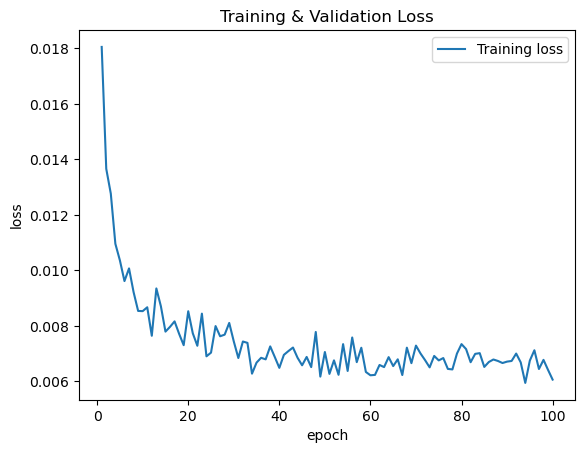

In [10]:
plt.plot(range(1,len(Tloss)+1), Tloss, label='Training loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


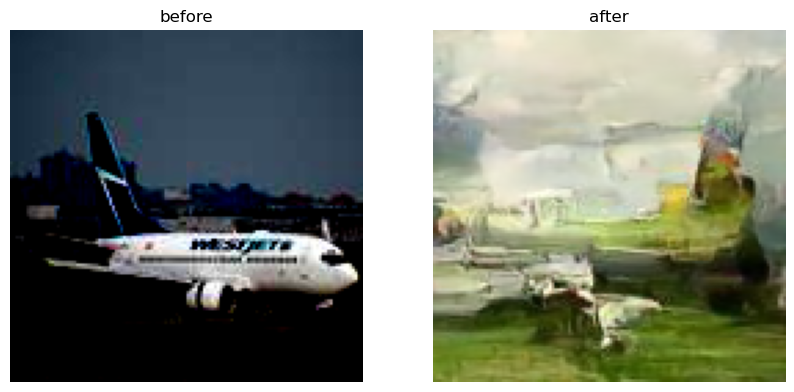

In [12]:
sketches, images = next((iter(train_loader)))
images, sketches = (2 * images.to(device) - 1, sketches.to(device),)
model.eval()
#pdb.set_trace()
t = torch.randint(diffusion.timesteps, (len(images),), dtype=torch.int64).to(
    device
)

xt, eps = diffusion.sample_from_forward_process(images, t) #diffusion.timesteps - 1)
pred_eps = model(xt, t, y=None)
#pdb.set_trace()
pred_eps=diffusion.sample_from_reverse_process(model, xt, diffusion.timesteps)
#pdb.set_trace()
pred_eps=(pred_eps.to(device) + 1) / 2

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(images[0].cpu().permute(1, 2, 0).detach().numpy())
ax[0].set_title('before')
ax[0].axis('off')

ax[1].imshow(pred_eps[0].cpu().permute(1, 2, 0).detach().numpy())
ax[1].set_title('after')
ax[1].axis('off')
plt.show()



In [14]:
torch.save(model.state_dict(), 'model.pth')